Resources Needed:
<br>
* resources/US_Accidents_Dec20_Updated.csv
* resources/{year}_vehicle_reg.xlsx
* resources/state_population_data_july2020.csv
* output_tables/road_distance_by_state.csv
* output_tables/land_area_by_state.csv
* resources/blue_laws.csv
* output_tables/weed_legalization_raw_scrape.csv

This notebook can take up to 1min to run, most of the time is spent importing the US_Accidents_Dec20_Updated dataset.

In [1]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
new_states = {v:k for k,v in us_state_abbrev.items()}

In [2]:
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Import Accident Dataset (1GB)

In [3]:
accidents = pd.read_csv('resources/US_Accidents_Dec20_Updated.csv')
dropthese = ['ID', 'End_Lat', 'End_Lng', 'End_Time', 'Description']
accidents = accidents.drop(columns = dropthese, axis = 1)
accidents['Start_Time'] = pd.to_datetime(accidents['Start_Time'])
accidents.head()

,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Number,Street,Side,City,County,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,2,2019-05-21 08:29:55,34.808868,-82.269157,0.0,439.0,Tanner Rd,R,Greenville,Greenville,...,False,False,False,False,False,False,Day,Day,Day,Day
1,2,2019-10-07 17:43:09,35.090080,-80.745560,0.0,3299.0,Providence Branch Ln,R,Charlotte,Mecklenburg,...,False,False,False,False,False,False,Day,Day,Day,Day
2,2,2020-12-13 21:53:00,37.145730,-121.985052,1.4,NaN,Santa Cruz Hwy,R,Los Gatos,Santa Clara,...,False,False,False,False,False,False,Night,Night,Night,Night
3,2,2018-04-17 16:51:23,39.110390,-119.773781,0.0,NaN,US Highway 395 S,R,Carson City,Douglas,...,False,False,False,False,True,False,Day,Day,Day,Day
4,3,2016-08-31 17:40:49,26.102942,-80.265091,0.0,NaN,I-595 W,R,Fort Lauderdale,Broward,...,False,False,False,False,True,False,Day,Day,Day,Day


In [4]:
len(accidents.index)

2906610

# Function to make Datasets of Accidents by Year (Joined with Vehicle Registration Data of the same year)

In [5]:
def make_df_by_year(year):
    
    registrations = pd.read_excel(f'resources/{year}_vehicle_reg.xlsx', header = 7)
    registrations.columns = [str(i) for i in range(len(registrations.columns))]
    registrations = registrations.set_index('0')

    col1 = ['Automobiles','Buses','Trucks','Motorcycles','All Vehicles']
    col2 = ['PRIVATE/COMMERCIAL','PUBLICALLY_OWNED','TOTAL']
    col_tier = []
    for i in col1:
        for j in col2:
            col_tier.append((i,j))
    registrations.columns = pd.MultiIndex.from_tuples(col_tier)
    starting_point = registrations.index.to_list().index('Alabama')
    registrations = registrations[starting_point:].dropna()

    for i in registrations.columns:
        registrations[i] = pd.to_numeric(registrations[i])
    
    
    year_start = f"{year}-01-01"
    year_end = f"{year+1}-01-01"
    accidents_output = accidents[(accidents['Start_Time'] > year_start) & (accidents['Start_Time'] < year_end)]
    
    transform = accidents_output.groupby(['State','Severity']).count()['Start_Time'].reset_index().rename(columns = {'Start_Time':'Count'})

    count_crashes = accidents_output[['State','Severity']].groupby(['State']).count()
    count_crashes = count_crashes.reset_index()
    count_crashes['State'] = count_crashes['State'].apply(lambda x: new_states[x])
    
    #-- Make Severity
    severity_1 = []
    severity_2 = []
    severity_3 = []
    severity_4 = []

    states = list(transform['State'].unique())
    for i in states:
        state_only = transform[transform['State'] == i]
        sev_1 = state_only[state_only['Severity'] == 1]
        sev_2 = state_only[state_only['Severity'] == 2]
        sev_3 = state_only[state_only['Severity'] == 3]
        sev_4 = state_only[state_only['Severity'] == 4]

        if len(sev_1.index) > 0:
            severity_1.append(int(sev_1['Count']))
        else:
            severity_1.append(0)

        if len(sev_2.index) > 0:
            severity_2.append(int(sev_2['Count']))
        else:
            severity_2.append(0)

        if len(sev_3.index) > 0:
            severity_3.append(int(sev_3['Count']))
        else:
            severity_3.append(0)

        if len(sev_4.index) > 0:
            severity_4.append(int(sev_4['Count']))
        else:
            severity_4.append(0)
            
    state_by_severity = pd.DataFrame({'State': list(transform['State'].unique()),
             'Severity_1': severity_1,
             'Severity_2': severity_2,
             'Severity_3': severity_3,
             'Severity_4': severity_4})
    
    state_by_severity['State'] = state_by_severity['State'].apply(lambda x: new_states[x])
    crash_count = f"Crash_Count_{year}"
    count_crashes.columns = ['State',crash_count]
    
    check = registrations['All Vehicles']['TOTAL'].to_dict()
    new_keys = []
    for k,v in check.items():
        if k.endswith(' '):
            new_keys.append(k[:-1])
        elif k.endswith(' (2)'):
            new_keys.append(k.replace(' (2)',''))
        else:
            new_keys.append(k)

    new_out = {}
    for i,j in enumerate(check.values()):
        new_out[new_keys[i]] = j
    new_out['District of Columbia'] = new_out.pop('Dist. of Col.')

    new_out.pop('Total')
    
    reg_vehicles = f"Registered_Vehicles_{year}"
    new_out = {
        'State': list(new_out.keys()),
        reg_vehicles: list(new_out.values())
    }
    
    vehicle_reg = pd.DataFrame(new_out)
    crash_reg = count_crashes.merge(vehicle_reg, how = 'left', on = 'State').merge(state_by_severity, how = 'left', on ='State')
    crash_reg['Crash_Index'] = crash_reg[crash_count]/ crash_reg[reg_vehicles]
    return crash_reg

In [6]:
def just_2020(year = 2020):
    year_start = f"{year}-01-01"
    year_end = f"{year+1}-01-01"
    accidents_output = accidents[(accidents['Start_Time'] > year_start) & (accidents['Start_Time'] < year_end)]
    
    transform = accidents_output.groupby(['State','Severity']).count()['Start_Time'].reset_index().rename(columns = {'Start_Time':'Count'})

    count_crashes = accidents_output[['State','Severity']].groupby(['State']).count()
    count_crashes = count_crashes.reset_index()
    count_crashes['State'] = count_crashes['State'].apply(lambda x: new_states[x])
    
    #-- Make Severity
    severity_1 = []
    severity_2 = []
    severity_3 = []
    severity_4 = []

    states = list(transform['State'].unique())
    for i in states:
        state_only = transform[transform['State'] == i]
        sev_1 = state_only[state_only['Severity'] == 1]
        sev_2 = state_only[state_only['Severity'] == 2]
        sev_3 = state_only[state_only['Severity'] == 3]
        sev_4 = state_only[state_only['Severity'] == 4]

        if len(sev_1.index) > 0:
            severity_1.append(int(sev_1['Count']))
        else:
            severity_1.append(0)

        if len(sev_2.index) > 0:
            severity_2.append(int(sev_2['Count']))
        else:
            severity_2.append(0)

        if len(sev_3.index) > 0:
            severity_3.append(int(sev_3['Count']))
        else:
            severity_3.append(0)

        if len(sev_4.index) > 0:
            severity_4.append(int(sev_4['Count']))
        else:
            severity_4.append(0)
            
    state_by_severity = pd.DataFrame({'State': list(transform['State'].unique()),
             'Severity_1': severity_1,
             'Severity_2': severity_2,
             'Severity_3': severity_3,
             'Severity_4': severity_4})
    
    state_by_severity['State'] = state_by_severity['State'].apply(lambda x: new_states[x])
    crash_count = f"Crash_Count_{year}"
    count_crashes.columns = ['State',crash_count]
    
    return count_crashes

In [7]:
twenty_no_reg = just_2020()
twenty_no_reg.head()

,State,Crash_Count_2020
0,Alabama,13650
1,Arkansas,3189
2,Arizona,24190
3,California,280498
4,Colorado,10353


# Make DFs with the above function

In [8]:
seventeen = make_df_by_year(2017)
eighteen = make_df_by_year(2018)
nineteen = make_df_by_year(2019)


In [9]:
seventeen.head()

,State,Crash_Count_2017,Registered_Vehicles_2017,Severity_1,Severity_2,Severity_3,Severity_4,Crash_Index
0,Alabama,1813,5.056073e+06,3,837,842,131,0.000359
1,Arkansas,95,2.833697e+06,0,29,13,53,0.000034
2,Arizona,7976,5.964434e+06,4,5706,1417,849,0.001337
3,California,95651,3.079514e+07,39,62232,31791,1589,0.003106
4,Colorado,4702,5.259960e+06,1,2848,1162,691,0.000894


In [10]:
eighteen.head()

,State,Crash_Count_2018,Registered_Vehicles_2018,Severity_1,Severity_2,Severity_3,Severity_4,Crash_Index
0,Alabama,7544,5.300199e+06,7,4529,2857,151,0.001423
1,Arkansas,491,2.817145e+06,0,201,98,192,0.000174
2,Arizona,13138,5.806313e+06,2,9479,2803,854,0.002263
3,California,98862,3.102233e+07,23,63912,33351,1576,0.003187
4,Colorado,8981,5.356018e+06,1,4842,3344,794,0.001677


In [11]:
nineteen.head()

,State,Crash_Count_2019,Registered_Vehicles_2019,Severity_1,Severity_2,Severity_3,Severity_4,Crash_Index
0,Alabama,10148,5.288208e+06,2,7525,2471,150,0.001919
1,Arkansas,925,2.902111e+06,0,516,227,182,0.000319
2,Arizona,13633,5.982559e+06,3,10400,2379,851,0.002279
3,California,168526,3.124727e+07,9,140611,26024,1882,0.005393
4,Colorado,11920,5.412404e+06,1,4254,6455,1210,0.002202


In [12]:
for i in list(nineteen.index):
    if i not in list(eighteen.index):
        print(f'not in eighteen: {i}')
    if i not in list(seventeen.index):
        print(f'not in nineteen: {i}')

# Combining Crash Indexes into one output

In [13]:
index_by_state = pd.DataFrame({
    'State': nineteen.State,
    'CrashCount_2017':seventeen['Crash_Count_2017'],
    'CrashCount_2018':eighteen['Crash_Count_2018'],
    'CrashCount_2019':nineteen['Crash_Count_2019'],
    'CrashCount_2020':twenty_no_reg['Crash_Count_2020'],
    'RegisteredVehicles_2017':seventeen['Registered_Vehicles_2017'],
    'RegisteredVehicles_2018':eighteen['Registered_Vehicles_2018'],
    'RegisteredVehicles_2019':nineteen['Registered_Vehicles_2019'],
})
index_by_state.head(10)

,State,CrashCount_2017,CrashCount_2018,CrashCount_2019,CrashCount_2020,RegisteredVehicles_2017,RegisteredVehicles_2018,RegisteredVehicles_2019
0,Alabama,1813,7544,10148,13650,5.056073e+06,5.300199e+06,5.288208e+06
1,Arkansas,95,491,925,3189,2.833697e+06,2.817145e+06,2.902111e+06
2,Arizona,7976,13138,13633,24190,5.964434e+06,5.806313e+06,5.982559e+06
3,California,95651,98862,168526,280498,3.079514e+07,3.102233e+07,3.124727e+07
4,Colorado,4702,8981,11920,10353,5.259960e+06,5.356018e+06,5.412404e+06
5,Connecticut,4579,4278,3588,8489,2.826350e+06,2.879802e+06,2.878548e+06
6,District of Columbia,536,736,940,2683,3.460160e+05,3.519326e+05,3.504632e+05
7,Delaware,640,1024,908,1807,9.707329e+05,1.008468e+06,1.016927e+06
8,Florida,38775,40019,35407,125154,1.695927e+07,1.749600e+07,1.783372e+07
9,Georgia,13635,15624,14559,17441,8.442325e+06,8.512550e+06,8.594567e+06


# Importing Population Data

In [14]:
pop_data = pd.read_csv('resources/state_population_data_july2020.csv').drop(columns = ['SUMLEV', 'CENSUS2010POP', 'STATE','REGION','DIVISION'], axis = 1)
pop_data.head()

,NAME,SEX,ORIGIN,RACE,AGE,POPESTIMATE2019
0,Alabama,0,0,1,0,35594
1,Alabama,0,0,1,1,36679
2,Alabama,0,0,1,2,37904
3,Alabama,0,0,1,3,38510
4,Alabama,0,0,1,4,38476


# We only care about people over 16

## Please note: Sex "0" is total of Sex "1" and Sex "2", we do not need Sex "0"

We also have no crash data for Hawaii or Alaska, they will be dropped when the left merge happens

In [15]:
print(f"Length of Raw State Population Dataset: {len(pop_data.index)}")

Length of Raw State Population Dataset: 236844


In [16]:
pop_data = pop_data[(pop_data['AGE'] > 15) & (pop_data['SEX'] > 0)].rename(columns = {'NAME':'State'})
pop_data.head()

,State,SEX,ORIGIN,RACE,AGE,POPESTIMATE2019
1564,Alabama,1,0,1,16,20748
1565,Alabama,1,0,1,17,20711
1566,Alabama,1,0,1,18,20741
1567,Alabama,1,0,1,19,20398
1568,Alabama,1,0,1,20,20506


In [17]:
print(f"Length of Filtered State Population Dataset: {len(pop_data.index)}")

Length of Filtered State Population Dataset: 128520


# Total Pop per state by Sex

In [18]:
sex_by_state = pop_data.groupby(['State','SEX']).sum()['POPESTIMATE2019'].reset_index()
sex1 = sex_by_state[sex_by_state['SEX'] == 1][['State','POPESTIMATE2019']].rename(columns = {'POPESTIMATE2019':'Sex_1_Pop'})
sex2 = sex_by_state[sex_by_state['SEX'] == 2][['State','POPESTIMATE2019']].rename(columns = {'POPESTIMATE2019':'Sex_2_Pop'})
sexes = sex1.merge(sex2, how = 'left', on = 'State')
sexes.head()

,State,Sex_1_Pop,Sex_2_Pop
0,Alabama,3756166,4121078
1,Alaska,597262,543368
2,Arizona,5750252,5896632
3,Arkansas,2326922,2466136
4,California,31216500,32017116


# Total Pop per state by Race

In [19]:
race_by_state = pop_data.groupby(['RACE','State']).sum()['POPESTIMATE2019'].reset_index()

# making an output dataframe
out = {'State':race_by_state[race_by_state['RACE'] == 1]['State']}
for i in range(1, max(race_by_state['RACE'].unique()) + 1):
    title = f"Race_{i}_Pop"
    out[title] = race_by_state[race_by_state['RACE'] == i]['POPESTIMATE2019'].to_list()

race_by_state = pd.DataFrame(out)
race_by_state.head()

,State,Race_1_Pop,Race_2_Pop,Race_3_Pop,Race_4_Pop,Race_5_Pop,Race_6_Pop
0,Alabama,5535308,2060146,56634,118462,7804,98890
1,Alaska,779052,42656,161364,77782,15036,64740
2,Arizona,9774984,576770,559436,445012,31754,258928
3,Arkansas,3852758,720534,47704,79818,16024,76220
4,California,45476790,4126560,1024614,10277334,316162,2012156


# Total Pop per state by Origin

In [20]:
origin_by_state = pop_data.groupby(['ORIGIN','State']).sum()['POPESTIMATE2019'].reset_index()

# making an output dataframe
out = {'State':origin_by_state[origin_by_state['ORIGIN'] == 1]['State']}
for i in range(0, max(origin_by_state['ORIGIN'].unique()) + 1):
    title = f"Origin_{i}_Pop"
    out[title] = origin_by_state[origin_by_state['ORIGIN'] == i]['POPESTIMATE2019'].to_list()

origin_by_state = pd.DataFrame(out)
origin_by_state.head()

,State,Origin_0_Pop,Origin_1_Pop,Origin_2_Pop
51,Alabama,3938622,3796692,141930
52,Alaska,570315,533461,36854
53,Arizona,5823442,4161567,1661875
54,Arkansas,2396529,2239461,157068
55,California,31616808,20157843,11458965


# Merging Population Data

In [21]:
index_by_state = index_by_state.merge(sexes, how = 'left', on = 'State').merge(race_by_state, how = 'left', on = 'State').merge(origin_by_state, how = 'left', on = 'State')
index_by_state

,State,CrashCount_2017,CrashCount_2018,CrashCount_2019,CrashCount_2020,RegisteredVehicles_2017,RegisteredVehicles_2018,RegisteredVehicles_2019,Sex_1_Pop,Sex_2_Pop,Race_1_Pop,Race_2_Pop,Race_3_Pop,Race_4_Pop,Race_5_Pop,Race_6_Pop,Origin_0_Pop,Origin_1_Pop,Origin_2_Pop
0,Alabama,1813,7544,10148,13650,5.056073e+06,5.300199e+06,5.288208e+06,3756166,4121078,5535308,2060146,56634,118462,7804,98890,3938622,3796692,141930
1,Arkansas,95,491,925,3189,2.833697e+06,2.817145e+06,2.902111e+06,2326922,2466136,3852758,720534,47704,79818,16024,76220,2396529,2239461,157068
2,Arizona,7976,13138,13633,24190,5.964434e+06,5.806313e+06,5.982559e+06,5750252,5896632,9774984,576770,559436,445012,31754,258928,5823442,4161567,1661875
3,California,95651,98862,168526,280498,3.079514e+07,3.102233e+07,3.124727e+07,31216500,32017116,45476790,4126560,1024614,10277334,316162,2012156,31616808,20157843,11458965
4,Colorado,4702,8981,11920,10353,5.259960e+06,5.356018e+06,5.412404e+06,4662722,4623020,8158550,411162,141074,331014,17500,226442,4642871,3737570,905301
5,Connecticut,4579,4278,3588,8489,2.826350e+06,2.879802e+06,2.878548e+06,2829874,3028820,4744064,685310,31340,285658,6164,106158,2929347,2492559,436788
6,District of Columbia,536,736,940,2683,3.460160e+05,3.519326e+05,3.504632e+05,549872,625840,563666,520262,6380,56520,1360,27524,587856,528635,59221
7,Delaware,640,1024,908,1807,9.707329e+05,1.008468e+06,1.016927e+06,759230,827602,1127352,352688,10262,64686,1554,30290,793416,730203,63213
8,Florida,38775,40019,35407,125154,1.695927e+07,1.749600e+07,1.783372e+07,17161930,18287566,27977026,5612238,177870,1062616,39046,580700,17724748,13270067,4454681
9,Georgia,13635,15624,14559,17441,8.442325e+06,8.512550e+06,8.594567e+06,8065024,8739416,10327490,5363292,84242,744524,18066,266826,8402220,7690632,711588


# Making a Total_Population Column

In [22]:
population_columns = [i for i in index_by_state.columns if i.endswith('Pop')]

total_pop = [0 for i in range(len(index_by_state.index))]
for i in population_columns:
    total_pop += index_by_state[i]
    
index_by_state['Total_2019_Pop'] = total_pop

# Importing Calculated Road Distance Dataset

In [23]:
road_dist = pd.read_csv('output_tables/road_distance_by_state.csv').rename(columns = {'state_name':'State'})
road_dist['sum_interstate_distance'] = road_dist['sum_interstate_distance'] * 3
road_dist['sum_highway_distance'] = road_dist['sum_highway_distance'] * 2
road_roads = road_dist.sort_values('sum_other_distance')['State'].to_list()
highway_roads = road_dist.sort_values('sum_highway_distance')['State'].to_list()
interstate_roads = road_dist.sort_values('sum_interstate_distance')['State'].to_list()
#pd.DataFrame({'road':road_roads,'highway':highway_roads,'interstate':interstate_roads})
road_dist.head()

,State,sum_interstate_distance,sum_highway_distance,sum_other_distance
0,Alabama,108.709435,168.630342,2055.135931
1,Arizona,119.118217,75.794702,1519.798416
2,Arkansas,72.395813,172.517366,2121.400732
3,California,244.633953,93.074124,4664.484637
4,Colorado,104.273956,210.519735,2022.606169


In [24]:
index_by_state = index_by_state.merge(road_dist, how = 'left', on = 'State')
index_by_state.head()

,State,CrashCount_2017,CrashCount_2018,CrashCount_2019,CrashCount_2020,RegisteredVehicles_2017,RegisteredVehicles_2018,RegisteredVehicles_2019,Sex_1_Pop,Sex_2_Pop,...,Race_4_Pop,Race_5_Pop,Race_6_Pop,Origin_0_Pop,Origin_1_Pop,Origin_2_Pop,Total_2019_Pop,sum_interstate_distance,sum_highway_distance,sum_other_distance
0,Alabama,1813,7544,10148,13650,5.056073e+06,5.300199e+06,5.288208e+06,3756166,4121078,...,118462,7804,98890,3938622,3796692,141930,23631732,108.709435,168.630342,2055.135931
1,Arkansas,95,491,925,3189,2.833697e+06,2.817145e+06,2.902111e+06,2326922,2466136,...,79818,16024,76220,2396529,2239461,157068,14379174,72.395813,172.517366,2121.400732
2,Arizona,7976,13138,13633,24190,5.964434e+06,5.806313e+06,5.982559e+06,5750252,5896632,...,445012,31754,258928,5823442,4161567,1661875,34940652,119.118217,75.794702,1519.798416
3,California,95651,98862,168526,280498,3.079514e+07,3.102233e+07,3.124727e+07,31216500,32017116,...,10277334,316162,2012156,31616808,20157843,11458965,189700848,244.633953,93.074124,4664.484637
4,Colorado,4702,8981,11920,10353,5.259960e+06,5.356018e+06,5.412404e+06,4662722,4623020,...,331014,17500,226442,4642871,3737570,905301,27857226,104.273956,210.519735,2022.606169


# Importing the Land Area Dataset made by the SrapingLandArea_byState.ipynb file

In [25]:
land_area = pd.read_csv('output_tables/land_area_by_state.csv')
land_area.head()

,State,Total_SqMi,Total_SqKm,LandArea_SqMi,LandArea_SqKm
0,Alabama,52420,135767,50645,131171
1,Alaska,665384,1723337,570641,1477953
2,Arizona,113990,295234,113594,294207
3,Arkansas,53179,137732,52035,134771
4,California,163695,423967,155779,403466


# We only care about the LandArea_SqMi Column

In [26]:
land_area = land_area[['State','LandArea_SqMi']]
land_area.head()

,State,LandArea_SqMi
0,Alabama,50645
1,Alaska,570641
2,Arizona,113594
3,Arkansas,52035
4,California,155779


In [27]:
index_by_state = index_by_state.merge(land_area, how = 'left',on = 'State')
index_by_state

,State,CrashCount_2017,CrashCount_2018,CrashCount_2019,CrashCount_2020,RegisteredVehicles_2017,RegisteredVehicles_2018,RegisteredVehicles_2019,Sex_1_Pop,Sex_2_Pop,...,Race_5_Pop,Race_6_Pop,Origin_0_Pop,Origin_1_Pop,Origin_2_Pop,Total_2019_Pop,sum_interstate_distance,sum_highway_distance,sum_other_distance,LandArea_SqMi
0,Alabama,1813,7544,10148,13650,5.056073e+06,5.300199e+06,5.288208e+06,3756166,4121078,...,7804,98890,3938622,3796692,141930,23631732,108.709435,168.630342,2055.135931,50645
1,Arkansas,95,491,925,3189,2.833697e+06,2.817145e+06,2.902111e+06,2326922,2466136,...,16024,76220,2396529,2239461,157068,14379174,72.395813,172.517366,2121.400732,52035
2,Arizona,7976,13138,13633,24190,5.964434e+06,5.806313e+06,5.982559e+06,5750252,5896632,...,31754,258928,5823442,4161567,1661875,34940652,119.118217,75.794702,1519.798416,113594
3,California,95651,98862,168526,280498,3.079514e+07,3.102233e+07,3.124727e+07,31216500,32017116,...,316162,2012156,31616808,20157843,11458965,189700848,244.633953,93.074124,4664.484637,155779
4,Colorado,4702,8981,11920,10353,5.259960e+06,5.356018e+06,5.412404e+06,4662722,4623020,...,17500,226442,4642871,3737570,905301,27857226,104.273956,210.519735,2022.606169,103642
5,Connecticut,4579,4278,3588,8489,2.826350e+06,2.879802e+06,2.878548e+06,2829874,3028820,...,6164,106158,2929347,2492559,436788,17576082,35.728563,22.533191,471.569466,4842
6,District of Columbia,536,736,940,2683,3.460160e+05,3.519326e+05,3.504632e+05,549872,625840,...,1360,27524,587856,528635,59221,3527136,1.188612,1.643633,20.552629,61
7,Delaware,640,1024,908,1807,9.707329e+05,1.008468e+06,1.016927e+06,759230,827602,...,1554,30290,793416,730203,63213,4760496,4.170596,14.776965,207.438202,1949
8,Florida,38775,40019,35407,125154,1.695927e+07,1.749600e+07,1.783372e+07,17161930,18287566,...,39046,580700,17724748,13270067,4454681,106348488,139.832291,222.032022,3012.123448,53625
9,Georgia,13635,15624,14559,17441,8.442325e+06,8.512550e+06,8.594567e+06,8065024,8739416,...,18066,266826,8402220,7690632,711588,50413320,118.769858,248.793350,2834.434202,57513


# Blue Laws
Source: https://worldpopulationreview.com/state-rankings/blue-laws-by-state
<br>
Binning by whether or not a state has restrictive measures against alcohol
<br>
### 0 = No Blue Laws, 1 = Some, 2 = Statewide

In [28]:
blue_df = pd.read_csv('resources/blue_laws.csv')
blue_df.blueLaws.value_counts()

No blue laws                       20
No vehicle sales                   11
Varies by County                   10
No hard liquor sales                5
No off-premise sales                3
No vehicle or hard liquor sales     1
Name: blueLaws, dtype: int64

In [29]:
blue_df.head()

,State,blueLaws
0,Oklahoma,Varies by County
1,New Mexico,Varies by County
2,Mississippi,Varies by County
3,Maryland,Varies by County
4,Louisiana,Varies by County


In [30]:
blue_df = blue_df.sort_values('State')
blue_df

,State,blueLaws
9,Alabama,Varies by County
49,Alaska,No blue laws
48,Arizona,No blue laws
8,Arkansas,Varies by County
47,California,No blue laws
20,Colorado,No vehicle sales
46,Connecticut,No blue laws
45,Delaware,No blue laws
7,Florida,Varies by County
6,Georgia,Varies by County


In [31]:
index_by_state = index_by_state.merge(blue_df, how = 'left', on = 'State')
index_by_state

,State,CrashCount_2017,CrashCount_2018,CrashCount_2019,CrashCount_2020,RegisteredVehicles_2017,RegisteredVehicles_2018,RegisteredVehicles_2019,Sex_1_Pop,Sex_2_Pop,...,Race_6_Pop,Origin_0_Pop,Origin_1_Pop,Origin_2_Pop,Total_2019_Pop,sum_interstate_distance,sum_highway_distance,sum_other_distance,LandArea_SqMi,blueLaws
0,Alabama,1813,7544,10148,13650,5.056073e+06,5.300199e+06,5.288208e+06,3756166,4121078,...,98890,3938622,3796692,141930,23631732,108.709435,168.630342,2055.135931,50645,Varies by County
1,Arkansas,95,491,925,3189,2.833697e+06,2.817145e+06,2.902111e+06,2326922,2466136,...,76220,2396529,2239461,157068,14379174,72.395813,172.517366,2121.400732,52035,Varies by County
2,Arizona,7976,13138,13633,24190,5.964434e+06,5.806313e+06,5.982559e+06,5750252,5896632,...,258928,5823442,4161567,1661875,34940652,119.118217,75.794702,1519.798416,113594,No blue laws
3,California,95651,98862,168526,280498,3.079514e+07,3.102233e+07,3.124727e+07,31216500,32017116,...,2012156,31616808,20157843,11458965,189700848,244.633953,93.074124,4664.484637,155779,No blue laws
4,Colorado,4702,8981,11920,10353,5.259960e+06,5.356018e+06,5.412404e+06,4662722,4623020,...,226442,4642871,3737570,905301,27857226,104.273956,210.519735,2022.606169,103642,No vehicle sales
5,Connecticut,4579,4278,3588,8489,2.826350e+06,2.879802e+06,2.878548e+06,2829874,3028820,...,106158,2929347,2492559,436788,17576082,35.728563,22.533191,471.569466,4842,No blue laws
6,District of Columbia,536,736,940,2683,3.460160e+05,3.519326e+05,3.504632e+05,549872,625840,...,27524,587856,528635,59221,3527136,1.188612,1.643633,20.552629,61,NaN
7,Delaware,640,1024,908,1807,9.707329e+05,1.008468e+06,1.016927e+06,759230,827602,...,30290,793416,730203,63213,4760496,4.170596,14.776965,207.438202,1949,No blue laws
8,Florida,38775,40019,35407,125154,1.695927e+07,1.749600e+07,1.783372e+07,17161930,18287566,...,580700,17724748,13270067,4454681,106348488,139.832291,222.032022,3012.123448,53625,Varies by County
9,Georgia,13635,15624,14559,17441,8.442325e+06,8.512550e+06,8.594567e+06,8065024,8739416,...,266826,8402220,7690632,711588,50413320,118.769858,248.793350,2834.434202,57513,Varies by County


# Importing Weed Legalization Data per State

In [32]:
weed = pd.read_csv('output_tables/weed_legalization_raw_scrape.csv').drop(columns = 'State Laws')
weed.columns = ['State','Weed_Legalization','Medicinal_Weed_Available','Weed_Decriminalized']

In [33]:
index_by_state = index_by_state.merge(weed, how = 'left', on = 'State')
index_by_state

,State,CrashCount_2017,CrashCount_2018,CrashCount_2019,CrashCount_2020,RegisteredVehicles_2017,RegisteredVehicles_2018,RegisteredVehicles_2019,Sex_1_Pop,Sex_2_Pop,...,Origin_2_Pop,Total_2019_Pop,sum_interstate_distance,sum_highway_distance,sum_other_distance,LandArea_SqMi,blueLaws,Weed_Legalization,Medicinal_Weed_Available,Weed_Decriminalized
0,Alabama,1813,7544,10148,13650,5.056073e+06,5.300199e+06,5.288208e+06,3756166,4121078,...,141930,23631732,108.709435,168.630342,2055.135931,50645,Varies by County,Mixed,Yes,No
1,Arkansas,95,491,925,3189,2.833697e+06,2.817145e+06,2.902111e+06,2326922,2466136,...,157068,14379174,72.395813,172.517366,2121.400732,52035,Varies by County,Mixed,Yes,No
2,Arizona,7976,13138,13633,24190,5.964434e+06,5.806313e+06,5.982559e+06,5750252,5896632,...,1661875,34940652,119.118217,75.794702,1519.798416,113594,No blue laws,Fully Legal,Yes,Yes
3,California,95651,98862,168526,280498,3.079514e+07,3.102233e+07,3.124727e+07,31216500,32017116,...,11458965,189700848,244.633953,93.074124,4664.484637,155779,No blue laws,Fully Legal,Yes,Yes
4,Colorado,4702,8981,11920,10353,5.259960e+06,5.356018e+06,5.412404e+06,4662722,4623020,...,905301,27857226,104.273956,210.519735,2022.606169,103642,No vehicle sales,Fully Legal,Yes,Yes
5,Connecticut,4579,4278,3588,8489,2.826350e+06,2.879802e+06,2.878548e+06,2829874,3028820,...,436788,17576082,35.728563,22.533191,471.569466,4842,No blue laws,Mixed,Yes,Yes
6,District of Columbia,536,736,940,2683,3.460160e+05,3.519326e+05,3.504632e+05,549872,625840,...,59221,3527136,1.188612,1.643633,20.552629,61,NaN,Fully Legal,Yes,Yes
7,Delaware,640,1024,908,1807,9.707329e+05,1.008468e+06,1.016927e+06,759230,827602,...,63213,4760496,4.170596,14.776965,207.438202,1949,No blue laws,Mixed,Yes,Yes
8,Florida,38775,40019,35407,125154,1.695927e+07,1.749600e+07,1.783372e+07,17161930,18287566,...,4454681,106348488,139.832291,222.032022,3012.123448,53625,Varies by County,Mixed,Yes,No
9,Georgia,13635,15624,14559,17441,8.442325e+06,8.512550e+06,8.594567e+06,8065024,8739416,...,711588,50413320,118.769858,248.793350,2834.434202,57513,Varies by County,Mixed,CBD Oil Only,No


# Bucketing Avg Severity by State Because Sam Young is Smart

In [34]:
import matplotlib.pyplot as plt

In [35]:
avg_severity = accidents.groupby('State').mean()['Severity'].reset_index()

<AxesSubplot:ylabel='Density'>

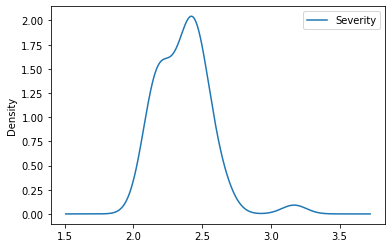

In [36]:
avg_severity.plot.density()

In [37]:
print(f"bottom:     {min(avg_severity['Severity'].to_list())}")
print(f"quartile 1: {avg_severity['Severity'].quantile(q=0.25)}")
print(f"quartile 2: {avg_severity['Severity'].quantile(q=0.50)}")
print(f"quartile 3: {avg_severity['Severity'].quantile(q=0.75)}")

bottom:     2.062634989200864
quartile 1: 2.20128
quartile 2: 2.3824807756603144
quartile 3: 2.471103556485356


In [38]:
def danger_bucket(dataset):
    
    bottom = min(dataset['Severity'].to_list())
    quart1 = dataset['Severity'].quantile(q=0.25)
    quart2 = dataset['Severity'].quantile(q=0.50)
    quart3 = dataset['Severity'].quantile(q=0.75)

    list_to_convert = dataset['Severity'].to_list()
    
    output = []
    for i in list_to_convert:
        if i >= quart3:
            output.append('High Severity')
        elif i >= quart2:
            output.append('Med-High Severity')
        elif i >= quart1:
            output.append('Medium Severity')
        else:
            output.append('Low Severity')
    return output

In [39]:
avg_severity['Severity_cat'] = danger_bucket(avg_severity)
avg_severity['State'] = avg_severity['State'].apply(lambda x: new_states[x])

In [40]:
avg_severity

,State,Severity,Severity_cat
0,Alabama,2.292250,Medium Severity
1,Arkansas,2.382141,Medium Severity
2,Arizona,2.144376,Low Severity
3,California,2.202665,Medium Severity
4,Colorado,2.609979,High Severity
5,Connecticut,2.515174,High Severity
6,District of Columbia,2.412998,Med-High Severity
7,Delaware,2.488000,High Severity
8,Florida,2.248777,Medium Severity
9,Georgia,2.633355,High Severity


In [41]:
index_by_state = index_by_state.merge(avg_severity, how = 'left', on = 'State').rename(columns = {'Severity':'Severity_avg'})
index_by_state

,State,CrashCount_2017,CrashCount_2018,CrashCount_2019,CrashCount_2020,RegisteredVehicles_2017,RegisteredVehicles_2018,RegisteredVehicles_2019,Sex_1_Pop,Sex_2_Pop,...,sum_interstate_distance,sum_highway_distance,sum_other_distance,LandArea_SqMi,blueLaws,Weed_Legalization,Medicinal_Weed_Available,Weed_Decriminalized,Severity_avg,Severity_cat
0,Alabama,1813,7544,10148,13650,5.056073e+06,5.300199e+06,5.288208e+06,3756166,4121078,...,108.709435,168.630342,2055.135931,50645,Varies by County,Mixed,Yes,No,2.292250,Medium Severity
1,Arkansas,95,491,925,3189,2.833697e+06,2.817145e+06,2.902111e+06,2326922,2466136,...,72.395813,172.517366,2121.400732,52035,Varies by County,Mixed,Yes,No,2.382141,Medium Severity
2,Arizona,7976,13138,13633,24190,5.964434e+06,5.806313e+06,5.982559e+06,5750252,5896632,...,119.118217,75.794702,1519.798416,113594,No blue laws,Fully Legal,Yes,Yes,2.144376,Low Severity
3,California,95651,98862,168526,280498,3.079514e+07,3.102233e+07,3.124727e+07,31216500,32017116,...,244.633953,93.074124,4664.484637,155779,No blue laws,Fully Legal,Yes,Yes,2.202665,Medium Severity
4,Colorado,4702,8981,11920,10353,5.259960e+06,5.356018e+06,5.412404e+06,4662722,4623020,...,104.273956,210.519735,2022.606169,103642,No vehicle sales,Fully Legal,Yes,Yes,2.609979,High Severity
5,Connecticut,4579,4278,3588,8489,2.826350e+06,2.879802e+06,2.878548e+06,2829874,3028820,...,35.728563,22.533191,471.569466,4842,No blue laws,Mixed,Yes,Yes,2.515174,High Severity
6,District of Columbia,536,736,940,2683,3.460160e+05,3.519326e+05,3.504632e+05,549872,625840,...,1.188612,1.643633,20.552629,61,NaN,Fully Legal,Yes,Yes,2.412998,Med-High Severity
7,Delaware,640,1024,908,1807,9.707329e+05,1.008468e+06,1.016927e+06,759230,827602,...,4.170596,14.776965,207.438202,1949,No blue laws,Mixed,Yes,Yes,2.488000,High Severity
8,Florida,38775,40019,35407,125154,1.695927e+07,1.749600e+07,1.783372e+07,17161930,18287566,...,139.832291,222.032022,3012.123448,53625,Varies by County,Mixed,Yes,No,2.248777,Medium Severity
9,Georgia,13635,15624,14559,17441,8.442325e+06,8.512550e+06,8.594567e+06,8065024,8739416,...,118.769858,248.793350,2834.434202,57513,Varies by County,Mixed,CBD Oil Only,No,2.633355,High Severity


# Finalizing the Crash Index Metric
### Currently, the Crash_Index_by_Registration column is the number of accidents / number of cars registered by state

In [45]:
index_by_state['TotalCrashes_2017-2019'] = (index_by_state['CrashCount_2017'] + index_by_state['CrashCount_2018'] + index_by_state['CrashCount_2019'])
index_by_state['TotalRegisteredVehicles_2017-2019'] = (index_by_state['RegisteredVehicles_2017'] + index_by_state['RegisteredVehicles_2018'] + index_by_state['RegisteredVehicles_2018'])

In [47]:
index_by_state['Avg_Crashes_Yr'] = index_by_state['TotalCrashes_2017-2019'] / 3
index_by_state['Avg_Registration_Yr'] = index_by_state['TotalRegisteredVehicles_2017-2019'] / 3

# Getting Total Road Distance

In [46]:
index_by_state['total_road_distance'] = index_by_state['sum_interstate_distance'] + index_by_state['sum_highway_distance'] + index_by_state['sum_other_distance']

# Getting Road Distance by Land Area per State
Land Area value is given by the web scrape done in another notebook

In [48]:
testing = pd.DataFrame()
testing['State'] = index_by_state['State']
testing['accidents_yr'] = index_by_state['Avg_Crashes_Yr']
testing['registered_cars'] = index_by_state['Avg_Registration_Yr']
testing['land'] = index_by_state['LandArea_SqMi']
testing['all_road'] = index_by_state['total_road_distance']
testing['total_road_by_land'] = index_by_state['total_road_distance'] / index_by_state['LandArea_SqMi']
testing['interstate_by_land'] = index_by_state['sum_interstate_distance'] / index_by_state['LandArea_SqMi']
testing['highway_by_land'] = index_by_state['sum_highway_distance'] / index_by_state['LandArea_SqMi']
testing['danger'] = index_by_state['Severity_cat']
testing['pop'] = index_by_state['Total_2019_Pop']
testing.head()

,State,accidents_yr,registered_cars,land,all_road,total_road_by_land,interstate_by_land,highway_by_land,danger,pop
0,Alabama,6501.666667,5.218824e+06,50645,2332.475708,0.046055,0.002146,0.003330,Medium Severity,23631732
1,Arkansas,503.666667,2.822663e+06,52035,2366.313911,0.045475,0.001391,0.003315,Medium Severity,14379174
2,Arizona,11582.333333,5.859020e+06,113594,1714.711335,0.015095,0.001049,0.000667,Low Severity,34940652
3,California,121013.000000,3.094660e+07,155779,5002.192714,0.032111,0.001570,0.000597,Medium Severity,189700848
4,Colorado,8534.333333,5.323999e+06,103642,2337.399861,0.022553,0.001006,0.002031,High Severity,27857226


In [49]:
testing['reg_vehicles_by_pop'] = (testing['registered_cars'] / testing['pop'])
testing[['State','total_road_by_land','reg_vehicles_by_pop','all_road']].sort_values('total_road_by_land')

,State,total_road_by_land,reg_vehicles_by_pop,all_road
31,Nevada,0.007048,0.168754,773.783176
48,Wyoming,0.011613,0.301360,1127.513435
30,New Mexico,0.013724,0.178597,1664.715634
24,Montana,0.013772,0.353326,2004.455758
42,Utah,0.014631,0.165880,1202.265688
2,Arizona,0.015095,0.167685,1714.711335
11,Idaho,0.018532,0.223668,1531.530518
4,Colorado,0.022553,0.191117,2337.399861
35,Oregon,0.024631,0.193125,2364.303309
39,South Dakota,0.025376,0.305740,1923.771288


# Crash Metric
### (Accidents Per State / Registered Cars Per State) * (Total State Road Distance / Registered Cars Per State)

In [50]:
non_interstate_roads = index_by_state['sum_highway_distance'] + index_by_state['sum_other_distance']
testing['registered_cars'] = testing['registered_cars'].apply(lambda x: round(x))
# creating a crash index by state - avg number of accidents per year by number of registered cars - the lower the number, the more infrequent accidents are per driver
testing['crash_index'] = (testing['accidents_yr'] / testing['registered_cars']) * 1000

# creating a road weight by cars registered per state - the higher the number, the more roadway is available per registered vehicle, small numbers are dense overpopulated areas
testing['road_weight'] = ((testing['all_road'] / testing['registered_cars'])) * 1000

#weighted_crash_index
testing['crash_index_weighted'] = (testing['crash_index'] * (index_by_state['sum_other_distance'] / testing['registered_cars']) * 1000) * testing['reg_vehicles_by_pop']

testing[['State','accidents_yr','registered_cars','all_road','reg_vehicles_by_pop','crash_index','road_weight','crash_index_weighted','danger']].sort_values('crash_index_weighted')

,State,accidents_yr,registered_cars,all_road,reg_vehicles_by_pop,crash_index,road_weight,crash_index_weighted,danger
39,South Dakota,16.333333,1265728,1923.771288,0.305740,0.012904,1.519893,0.005394,Med-High Severity
26,North Dakota,11.333333,952221,2177.752369,0.264761,0.011902,2.287024,0.006668,Low Severity
6,District of Columbia,737.333333,349960,23.384874,0.099219,2.106907,0.066822,0.012277,Med-High Severity
44,Vermont,136.666667,620332,371.773375,0.197340,0.220312,0.599314,0.022327,Med-High Severity
17,Massachusetts,5061.666667,5062739,879.085406,0.147944,0.999788,0.173638,0.023143,Medium Severity
24,Montana,139.666667,1834843,2004.455758,0.353326,0.076119,1.092440,0.025197,Low Severity
1,Arkansas,503.666667,2822663,2366.313911,0.196302,0.178437,0.838327,0.026325,Medium Severity
31,Nevada,1645.666667,2494706,773.783176,0.168754,0.659664,0.310170,0.027449,Medium Severity
29,New Jersey,9195.000000,6056163,947.289298,0.140778,1.518288,0.156417,0.030129,Medium Severity
11,Idaho,425.000000,1865081,1531.530518,0.223668,0.227872,0.821160,0.037085,Low Severity


<AxesSubplot:ylabel='Density'>

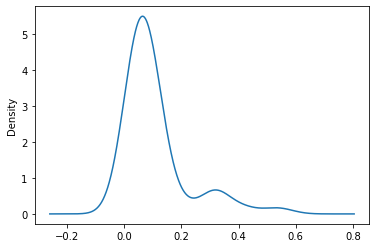

In [51]:
testing['crash_index_weighted'].plot.density()

# Merging the new Crash Index
### The higher the number, the more likely an accident is to occur per registered vehicle, weighted by the distance of roadway within the state

In [52]:
index_by_state['Crash_Index_Weighted'] = testing['crash_index_weighted']
index_by_state

,State,CrashCount_2017,CrashCount_2018,CrashCount_2019,CrashCount_2020,RegisteredVehicles_2017,RegisteredVehicles_2018,RegisteredVehicles_2019,Sex_1_Pop,Sex_2_Pop,...,Medicinal_Weed_Available,Weed_Decriminalized,Severity_avg,Severity_cat,TotalCrashes_2017-2019,TotalRegisteredVehicles_2017-2019,total_road_distance,Avg_Crashes_Yr,Avg_Registration_Yr,Crash_Index_Weighted
0,Alabama,1813,7544,10148,13650,5.056073e+06,5.300199e+06,5.288208e+06,3756166,4121078,...,Yes,No,2.292250,Medium Severity,19505,1.565647e+07,2332.475708,6501.666667,5.218824e+06,0.108342
1,Arkansas,95,491,925,3189,2.833697e+06,2.817145e+06,2.902111e+06,2326922,2466136,...,Yes,No,2.382141,Medium Severity,1511,8.467988e+06,2366.313911,503.666667,2.822663e+06,0.026325
2,Arizona,7976,13138,13633,24190,5.964434e+06,5.806313e+06,5.982559e+06,5750252,5896632,...,Yes,Yes,2.144376,Low Severity,34747,1.757706e+07,1714.711335,11582.333333,5.859020e+06,0.085986
3,California,95651,98862,168526,280498,3.079514e+07,3.102233e+07,3.124727e+07,31216500,32017116,...,Yes,Yes,2.202665,Medium Severity,363039,9.283980e+07,5002.192714,121013.000000,3.094660e+07,0.096151
4,Colorado,4702,8981,11920,10353,5.259960e+06,5.356018e+06,5.412404e+06,4662722,4623020,...,Yes,Yes,2.609979,High Severity,25603,1.597200e+07,2337.399861,8534.333333,5.323999e+06,0.116387
5,Connecticut,4579,4278,3588,8489,2.826350e+06,2.879802e+06,2.878548e+06,2829874,3028820,...,Yes,Yes,2.515174,High Severity,12445,8.585953e+06,529.831219,4148.333333,2.861984e+06,0.038889
6,District of Columbia,536,736,940,2683,3.460160e+05,3.519326e+05,3.504632e+05,549872,625840,...,Yes,Yes,2.412998,Med-High Severity,2212,1.049881e+06,23.384874,737.333333,3.499604e+05,0.012277
7,Delaware,640,1024,908,1807,9.707329e+05,1.008468e+06,1.016927e+06,759230,827602,...,Yes,Yes,2.488000,High Severity,2572,2.987668e+06,226.385763,857.333333,9.958894e+05,0.037512
8,Florida,38775,40019,35407,125154,1.695927e+07,1.749600e+07,1.783372e+07,17161930,18287566,...,Yes,No,2.248777,Medium Severity,114201,5.195127e+07,3373.987761,38067.000000,1.731709e+07,0.062261
9,Georgia,13635,15624,14559,17441,8.442325e+06,8.512550e+06,8.594567e+06,8065024,8739416,...,CBD Oil Only,No,2.633355,High Severity,43818,2.546743e+07,3201.997410,14606.000000,8.489142e+06,0.096736


In [53]:
index_by_state.sort_values('Crash_Index_Weighted')

,State,CrashCount_2017,CrashCount_2018,CrashCount_2019,CrashCount_2020,RegisteredVehicles_2017,RegisteredVehicles_2018,RegisteredVehicles_2019,Sex_1_Pop,Sex_2_Pop,...,Medicinal_Weed_Available,Weed_Decriminalized,Severity_avg,Severity_cat,TotalCrashes_2017-2019,TotalRegisteredVehicles_2017-2019,total_road_distance,Avg_Crashes_Yr,Avg_Registration_Yr,Crash_Index_Weighted
39,South Dakota,11,11,27,160,1.258356e+06,1.269415e+06,1.280969e+06,693734,686228,...,Yes,Yes,2.414747,Med-High Severity,49,3.797185e+06,1923.771288,16.333333,1.265728e+06,0.005394
26,North Dakota,1,18,15,426,1.056758e+06,8.999525e+05,9.036677e+05,613724,585120,...,Yes,Yes,2.062635,Low Severity,34,2.856663e+06,2177.752369,11.333333,9.522210e+05,0.006668
6,District of Columbia,536,736,940,2683,3.460160e+05,3.519326e+05,3.504632e+05,549872,625840,...,Yes,Yes,2.412998,Med-High Severity,2212,1.049881e+06,23.384874,737.333333,3.499604e+05,0.012277
44,Vermont,113,127,170,128,6.216080e+05,6.196937e+05,6.204282e+05,513382,534442,...,Yes,Yes,2.387387,Med-High Severity,410,1.860995e+06,371.773375,136.666667,6.203318e+05,0.022327
17,Massachusetts,5005,5192,4988,6930,5.065221e+06,5.061499e+06,5.061260e+06,5476316,5930546,...,Yes,Yes,2.376975,Medium Severity,15185,1.518822e+07,879.085406,5061.666667,5.062739e+06,0.023143
24,Montana,133,130,156,2852,1.813854e+06,1.845338e+06,1.900806e+06,867460,863562,...,Yes,Yes,2.105911,Low Severity,419,5.504530e+06,2004.455758,139.666667,1.834843e+06,0.025197
1,Arkansas,95,491,925,3189,2.833697e+06,2.817145e+06,2.902111e+06,2326922,2466136,...,Yes,No,2.382141,Medium Severity,1511,8.467988e+06,2366.313911,503.666667,2.822663e+06,0.026325
31,Nevada,1828,1456,1653,1518,2.455442e+06,2.514338e+06,2.546583e+06,2459646,2468038,...,Yes,Yes,2.356119,Medium Severity,4937,7.484119e+06,773.783176,1645.666667,2.494706e+06,0.027449
29,New Jersey,9430,9720,8435,16551,6.057711e+06,6.055389e+06,6.033015e+06,6933142,7406620,...,Yes,Yes,2.373043,Medium Severity,27585,1.816849e+07,947.289298,9195.000000,6.056163e+06,0.030129
11,Idaho,346,389,540,2471,1.835903e+06,1.879670e+06,1.954528e+06,1386122,1393422,...,No,No,2.193277,Low Severity,1275,5.595243e+06,1531.530518,425.000000,1.865081e+06,0.037085


In [54]:
index_by_state.to_csv('output_tables/data_grouped_by_state.csv', index = False)